# 📚 Hypothesis

We aim to investigate the impact of **Inflation** on three economic indicators:
- Property Prices (log-transformed)
- Unemployment Rate
- Consumption Expenditure (log-transformed)

## Hypotheses

- **Null Hypothesis (H₀):** Inflation has no significant effect on the economic indicators.
- **Alternative Hypothesis (H₁):** Inflation has a significant effect on the economic indicators.

We will use **Simple Linear Regression (OLS)** and evaluate significance based on **p-values** at a 5% significance level (α = 0.05).


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [104]:
# Define countries, file paths, file types, and date ranges
countries = {
    'Canada': {
        'property': "Real Residential Property Prices for Canada.csv",
        'unemployment': "Unemployment Rate Total in Canada.csv",
        'inflation': "Inflation, consumer prices for Canada.csv",
        'consumption': "Real Final Consumption Expenditure for Canada.csv",
        'file_type': 'csv',
        'start_date': '1970-01-01',
        'end_date': '2023-12-31'
    },
    'UK': {
        'property': "Real Residential Property Prices UK.csv",
        'unemployment': "Unemployment Rate Total in UK.csv",
        'inflation': "Inflation, consumer prices for UK.csv",
        'consumption': "Real Final Consumption Expenditure for United Kingdom.csv",
        'file_type': 'csv',
        'start_date': '1995-01-01',
        'end_date': '2023-12-31'
    },
    'USA': {
        'property': "Real Residential Property Prices for US.xlsx",
        'unemployment': "Unemployment Rate Total in US.csv",
        'inflation': "Inflation, consumer prices for United States.csv",
        'consumption': "Real Final Consumption Expenditure for US.csv",
        'file_type': 'excel',
        'start_date': '1971-01-01',
        'end_date': '2023-12-31'
    }
}

# Dictionary to store the merged datasets for each country
merged_datasets = {}

# Loop through each country
for country, info in countries.items():
    
    # Load datasets
    if info['file_type'] == 'csv':
        df_property = pd.read_csv(info['property'])
    else:
        df_property = pd.read_excel(info['property'], sheet_name="Quarterly")
    
    df_unemployment = pd.read_csv(info['unemployment'])
    df_inflation = pd.read_csv(info['inflation'])
    df_consumption = pd.read_csv(info['consumption'])

    # Convert date columns to datetime
    datasets = [df_property, df_unemployment, df_inflation, df_consumption]
    for df in datasets:
        df.columns = df.columns.str.lower()
        if 'observation_date' in df.columns:
            df['observation_date'] = pd.to_datetime(df['observation_date'])
        elif 'date' in df.columns:
            df.rename(columns={'date': 'observation_date'}, inplace=True)
            df['observation_date'] = pd.to_datetime(df['observation_date'])

    # Resample data to yearly averages
    df_property = df_property.set_index('observation_date').resample('Y').mean().reset_index()
    df_unemployment = df_unemployment.set_index('observation_date').resample('Y').mean().reset_index()
    df_inflation = df_inflation.set_index('observation_date').resample('Y').mean().reset_index()
    df_consumption = df_consumption.set_index('observation_date').resample('Y').mean().reset_index()

    # Filter based on date range
    start_date = info['start_date']
    end_date = info['end_date']
    
    df_property = df_property[(df_property['observation_date'] >= start_date) & (df_property['observation_date'] <= end_date)]
    df_unemployment = df_unemployment[(df_unemployment['observation_date'] >= start_date) & (df_unemployment['observation_date'] <= end_date)]
    df_inflation = df_inflation[(df_inflation['observation_date'] >= start_date) & (df_inflation['observation_date'] <= end_date)]
    df_consumption = df_consumption[(df_consumption['observation_date'] >= start_date) & (df_consumption['observation_date'] <= end_date)]

    # Merge all datasets on 'observation_date'
    merged = df_property.merge(df_unemployment, on='observation_date', how='inner', suffixes=('_property', '_unemployment'))
    merged = merged.merge(df_inflation, on='observation_date')
    merged = merged.merge(df_consumption, on='observation_date', suffixes=('_inflation', '_consumption'))

    # Rename columns for clarity
    merged.columns = ['Year', 'Property_Prices', 'Unemployment_Rate', 'Inflation', 'Consumption_Expenditure']
    
    # Store the merged dataset
    merged_datasets[country] = merged

# Define a function for missing value analysis
def missing_value_analysis(df, country_name):
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percent
    })
    print(f"\nMissing Value Analysis: {country_name}")
    print(missing_df)

# Apply missing value analysis for each country
for country, df in merged_datasets.items():
    missing_value_analysis(df, country)



Missing Value Analysis: Canada
                         Missing Count  Missing Percentage (%)
Year                                 0                     0.0
Property_Prices                      0                     0.0
Unemployment_Rate                    0                     0.0
Inflation                            0                     0.0
Consumption_Expenditure              0                     0.0

Missing Value Analysis: UK
                         Missing Count  Missing Percentage (%)
Year                                 0                     0.0
Property_Prices                      0                     0.0
Unemployment_Rate                    0                     0.0
Inflation                            0                     0.0
Consumption_Expenditure              0                     0.0

Missing Value Analysis: USA
                         Missing Count  Missing Percentage (%)
Year                                 0                     0.0
Property_Prices              

C:\Users\ihsan\AppData\Local\Temp\ipykernel_15088\1909001886.py:59: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_property = df_property.set_index('observation_date').resample('Y').mean().reset_index()
C:\Users\ihsan\AppData\Local\Temp\ipykernel_15088\1909001886.py:60: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_unemployment = df_unemployment.set_index('observation_date').resample('Y').mean().reset_index()
C:\Users\ihsan\AppData\Local\Temp\ipykernel_15088\1909001886.py:61: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_inflation = df_inflation.set_index('observation_date').resample('Y').mean().reset_index()
C:\Users\ihsan\AppData\Local\Temp\ipykernel_15088\1909001886.py:62: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_consumption = df_consumption.set_index

In [105]:
# Define numeric columns to check for outliers
numeric_columns = ['Property_Prices', 'Unemployment_Rate', 'Inflation', 'Consumption_Expenditure']

# Function to perform IQR-based outlier analysis
def outlier_analysis(df, country_name):
    outlier_summary = []

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        outlier_summary.append({
            'Feature': col,
            'Outlier Count': outliers.shape[0],
            'Outlier Percentage (%)': round(100 * outliers.shape[0] / df.shape[0], 2)
        })

    outlier_df = pd.DataFrame(outlier_summary)

    print(f"\nOutlier Analysis (IQR Method): {country_name}")
    print(outlier_df)

# Apply the outlier analysis for each country
for country, df in merged_datasets.items():
    outlier_analysis(df, country)



Outlier Analysis (IQR Method): Canada
                   Feature  Outlier Count  Outlier Percentage (%)
0          Property_Prices              2                    3.70
1        Unemployment_Rate              1                    1.85
2                Inflation              5                    9.26
3  Consumption_Expenditure              0                    0.00

Outlier Analysis (IQR Method): UK
                   Feature  Outlier Count  Outlier Percentage (%)
0          Property_Prices              1                    3.45
1        Unemployment_Rate              0                    0.00
2                Inflation              2                    6.90
3  Consumption_Expenditure              0                    0.00

Outlier Analysis (IQR Method): USA
                   Feature  Outlier Count  Outlier Percentage (%)
0          Property_Prices              1                    1.89
1        Unemployment_Rate              0                    0.00
2                Inflation      

In [106]:
# Function to apply winsorization and show comparison
def winsorize_inflation(df, country_name):
    # Backup the original inflation values
    inflation_original = df['Inflation'].copy()

    # Apply winsorization - limit bottom 5% and top 5%
    df['Inflation'] = winsorize(df['Inflation'], limits=[0.05, 0.05])

    # Compare summary statistics before and after
    inflation_comparison = pd.DataFrame({
        'Original': inflation_original.describe(),
        'Winsorized': df['Inflation'].describe()
    })

    print(f"\nInflation Winsorization Comparison: {country_name}")
    print(inflation_comparison)

# Apply the winsorization for each country
for country, df in merged_datasets.items():
    winsorize_inflation(df, country)



Inflation Winsorization Comparison: Canada
        Original  Winsorized
count  54.000000   54.000000
mean    3.967563    3.949751
std     3.129114    3.018593
min     0.165563    0.717000
25%     1.796968    1.796968
50%     2.712179    2.712179
75%     4.986927    4.986927
max    12.471612   10.768972

Inflation Winsorization Comparison: UK
        Original  Winsorized
count  29.000000   29.000000
mean    2.399823    2.382353
std     1.571226    1.411567
min     0.368047    0.989487
25%     1.520402    1.520402
50%     2.201143    2.201143
75%     2.557756    2.557756
max     7.922049    6.793967

Inflation Winsorization Comparison: USA
        Original  Winsorized
count  53.000000   53.000000
mean    4.002071    4.002260
std     2.883782    2.665443
min    -0.355546    1.233584
25%     2.188027    2.188027
50%     3.212435    3.212435
75%     4.697859    4.697859
max    13.549202   11.054805


c:\Users\ihsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ihsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ihsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(



Correlation Matrix: Canada
                         Inflation  Unemployment_Rate  Property_Prices  \
Inflation                 1.000000          -0.050778        -0.371623   
Unemployment_Rate        -0.050778           1.000000        -0.372524   
Property_Prices          -0.371623          -0.372524         1.000000   
Consumption_Expenditure  -0.563956          -0.307449         0.935320   

                         Consumption_Expenditure  
Inflation                              -0.563956  
Unemployment_Rate                      -0.307449  
Property_Prices                         0.935320  
Consumption_Expenditure                 1.000000  


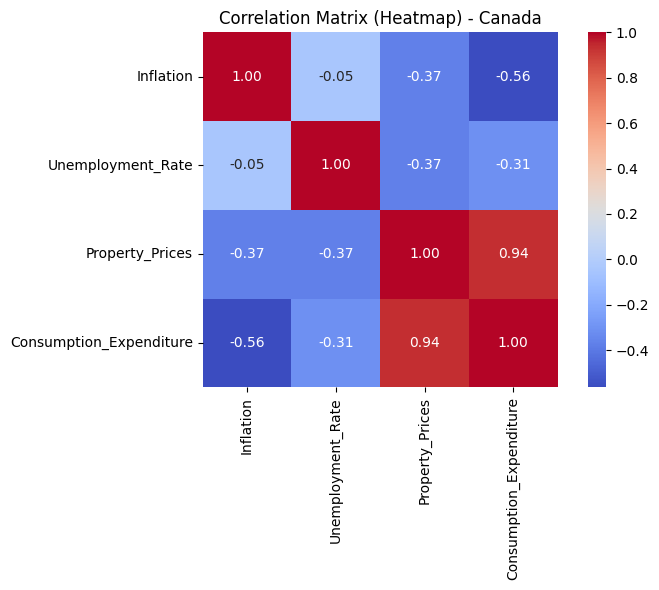


Correlation Matrix: UK
                         Inflation  Unemployment_Rate  Property_Prices  \
Inflation                 1.000000          -0.075372        -0.540971   
Unemployment_Rate        -0.075372           1.000000        -0.278485   
Property_Prices          -0.540971          -0.278485         1.000000   
Consumption_Expenditure   0.330470          -0.570264        -0.348884   

                         Consumption_Expenditure  
Inflation                               0.330470  
Unemployment_Rate                      -0.570264  
Property_Prices                        -0.348884  
Consumption_Expenditure                 1.000000  


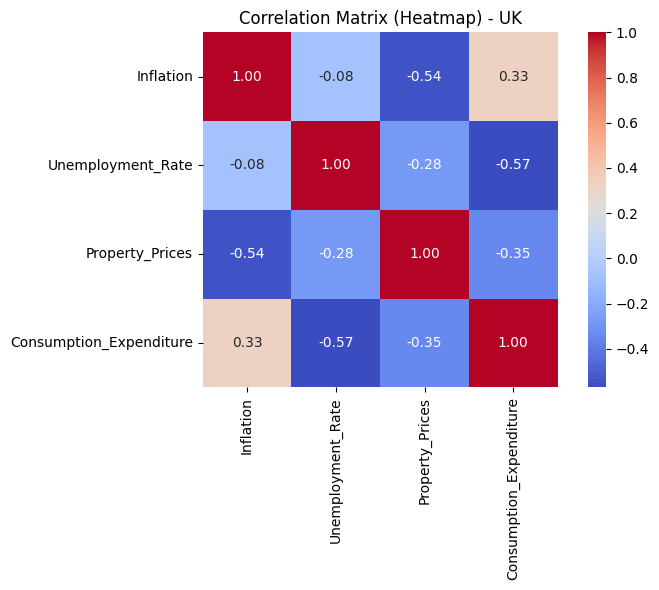


Correlation Matrix: USA
                         Inflation  Unemployment_Rate  Property_Prices  \
Inflation                 1.000000           0.089437        -0.101551   
Unemployment_Rate         0.089437           1.000000        -0.337610   
Property_Prices          -0.101551          -0.337610         1.000000   
Consumption_Expenditure  -0.528294          -0.343233         0.081725   

                         Consumption_Expenditure  
Inflation                              -0.528294  
Unemployment_Rate                      -0.343233  
Property_Prices                         0.081725  
Consumption_Expenditure                 1.000000  


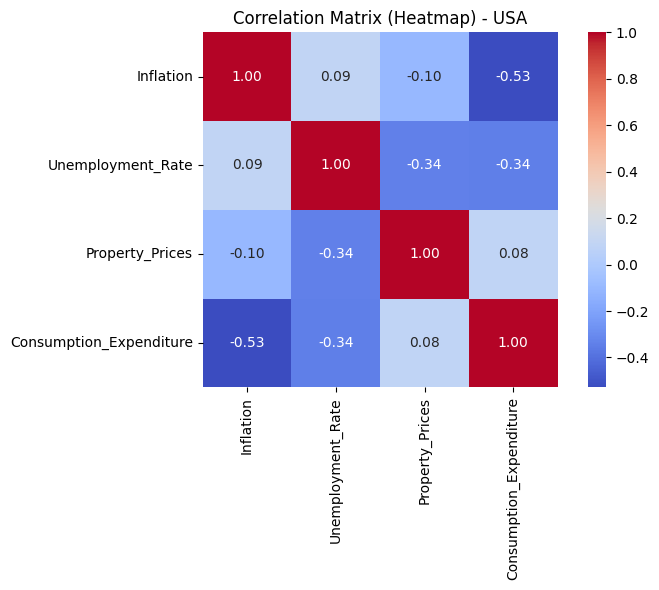

In [107]:
numeric_columns = ['Inflation', 'Unemployment_Rate', 'Property_Prices', 'Consumption_Expenditure']

# Function to calculate and plot correlation matrix
def correlation_analysis(df, country_name):
    # Calculate correlation matrix
    correlation_matrix = df[numeric_columns].corr()

    # Print the correlation matrix
    print(f"\nCorrelation Matrix: {country_name}")
    print(correlation_matrix)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"Correlation Matrix (Heatmap) - {country_name}")
    plt.tight_layout()
    plt.show()

# Apply the correlation analysis for each country
for country, df in merged_datasets.items():
    correlation_analysis(df, country)


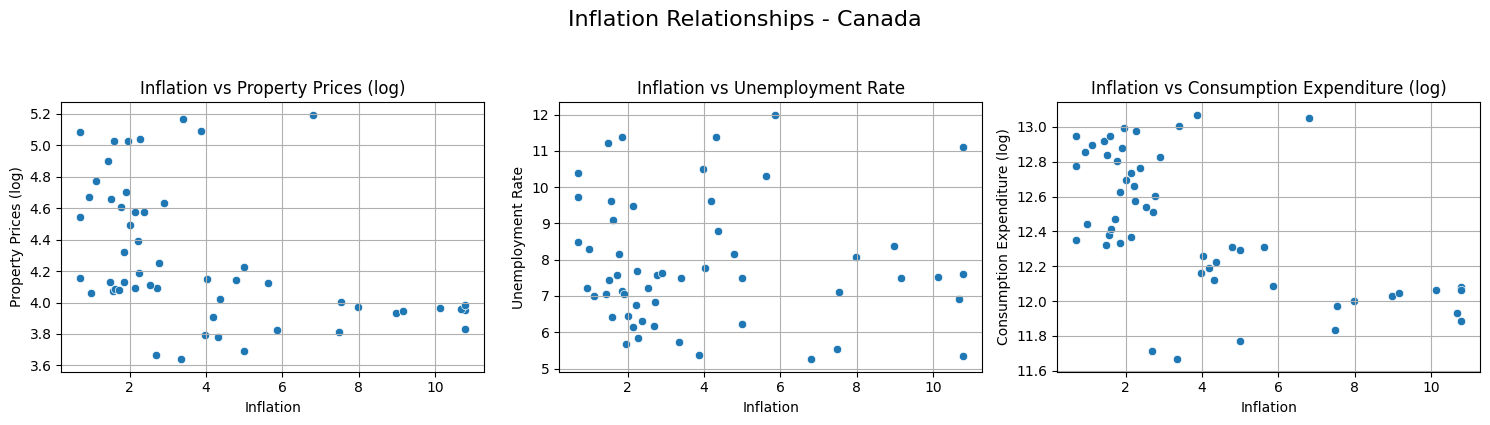

c:\Users\ihsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


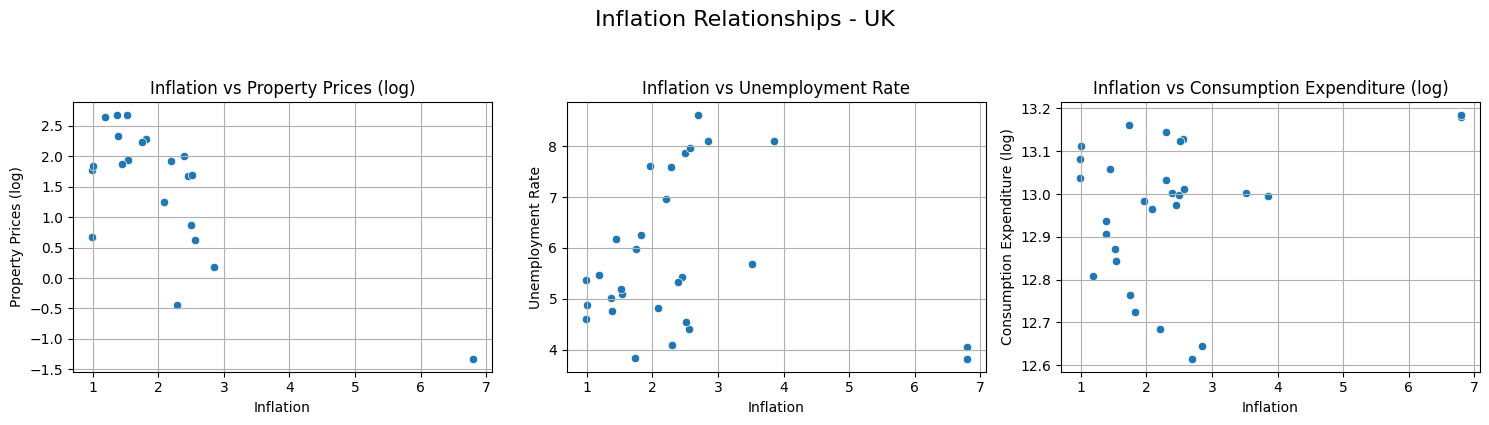

c:\Users\ihsan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


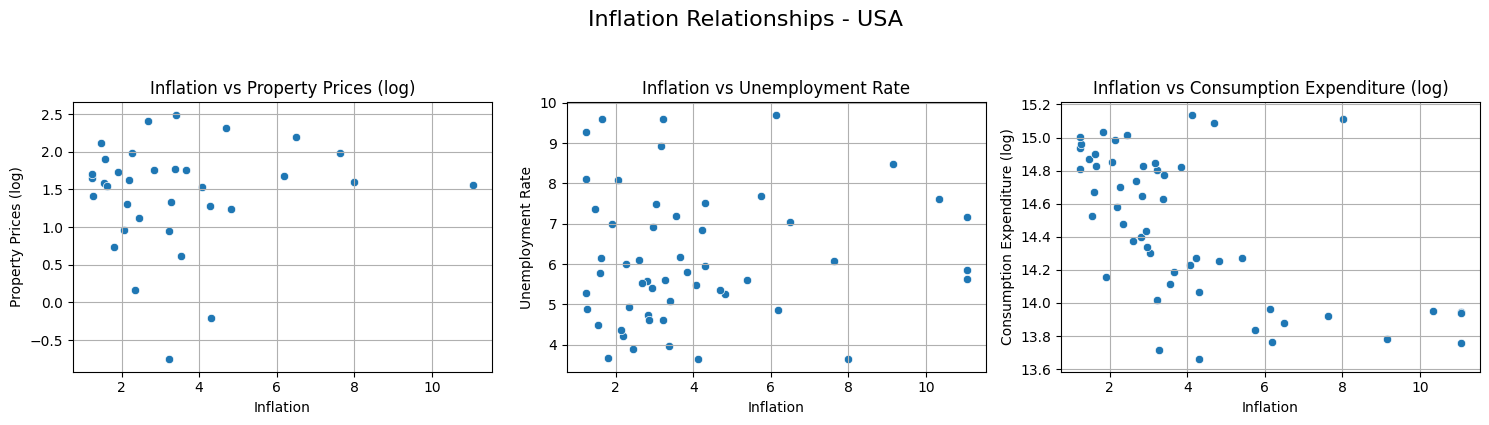

In [108]:
# Function to apply log transformations and plot scatter plots
def scatter_plots_with_log(df, country_name):
    # Apply log transformations
    df['Log_Property_Prices'] = np.log(df['Property_Prices'])
    df['Log_Consumption_Expenditure'] = np.log(df['Consumption_Expenditure'])

    # Define variables for plotting
    plot_vars = ['Log_Property_Prices', 'Unemployment_Rate', 'Log_Consumption_Expenditure']
    titles = ['Property Prices (log)', 'Unemployment Rate', 'Consumption Expenditure (log)']

    # Create scatter plots
    plt.figure(figsize=(15, 4))
    for i, y in enumerate(plot_vars):
        plt.subplot(1, 3, i + 1)
        sns.scatterplot(data=df, x='Inflation', y=y)
        plt.title(f'Inflation vs {titles[i]}')
        plt.xlabel('Inflation')
        plt.ylabel(titles[i])
        plt.grid(True)

    plt.suptitle(f'Inflation Relationships - {country_name}', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# Apply the scatter plotting function for each country
for country, df in merged_datasets.items():
    scatter_plots_with_log(df, country)


In [109]:
# Function to run OLS regressions and summarize results
def regression_summary_analysis(df, country_name):
    # Define independent variable (with constant)
    X = df[['Inflation']]
    X = sm.add_constant(X)

    # Define dependent variables
    dependent_vars = {
        'Log_Property_Prices': df['Log_Property_Prices'],
        'Unemployment_Rate': df['Unemployment_Rate'],
        'Log_Consumption_Expenditure': df['Log_Consumption_Expenditure']
    }

    # Collect regression results
    results = []

    for name, Y in dependent_vars.items():
        model = sm.OLS(Y, X, missing='drop').fit()
        results.append({
            'Dependent Variable': name,
            'Coefficient (Inflation)': model.params['Inflation'],
            'Intercept': model.params['const'],
            'R-squared': model.rsquared,
            'p-value (Inflation)': model.pvalues['Inflation']
        })

    # Create summary dataframe
    summary_df = pd.DataFrame(results)

    # Print the summary
    print(f"\n--- Regression Summary: {country_name} ---")
    print(summary_df.round(4))

# Apply the regression summary function for each country
for country, df in merged_datasets.items():
    regression_summary_analysis(df, country)



--- Regression Summary: Canada ---
            Dependent Variable  Coefficient (Inflation)  Intercept  R-squared  \
0          Log_Property_Prices                  -0.0630     4.5315     0.1929   
1            Unemployment_Rate                  -0.0292     7.9709     0.0026   
2  Log_Consumption_Expenditure                  -0.0793    12.7505     0.3720   

   p-value (Inflation)  
0               0.0009  
1               0.7154  
2               0.0000  

--- Regression Summary: UK ---
            Dependent Variable  Coefficient (Inflation)  Intercept  R-squared  \
0          Log_Property_Prices                  -0.6261     2.7952     0.5274   
1            Unemployment_Rate                  -0.0779     5.9651     0.0057   
2  Log_Consumption_Expenditure                   0.0335    12.8848     0.0853   

   p-value (Inflation)  
0               0.0002  
1               0.6976  
2               0.1242  

--- Regression Summary: USA ---
            Dependent Variable  Coefficient (Infl

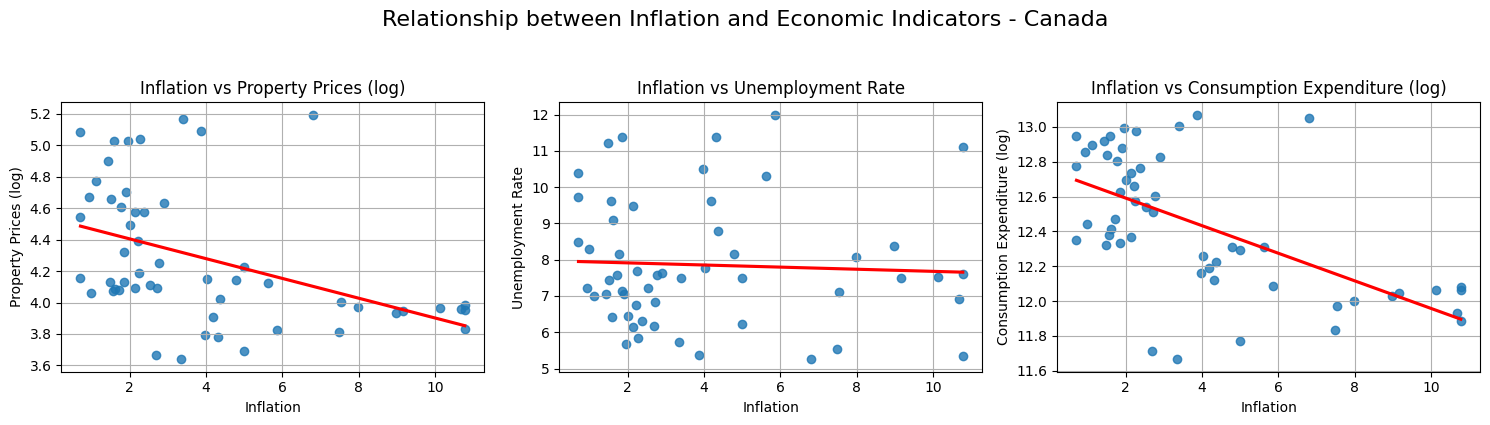

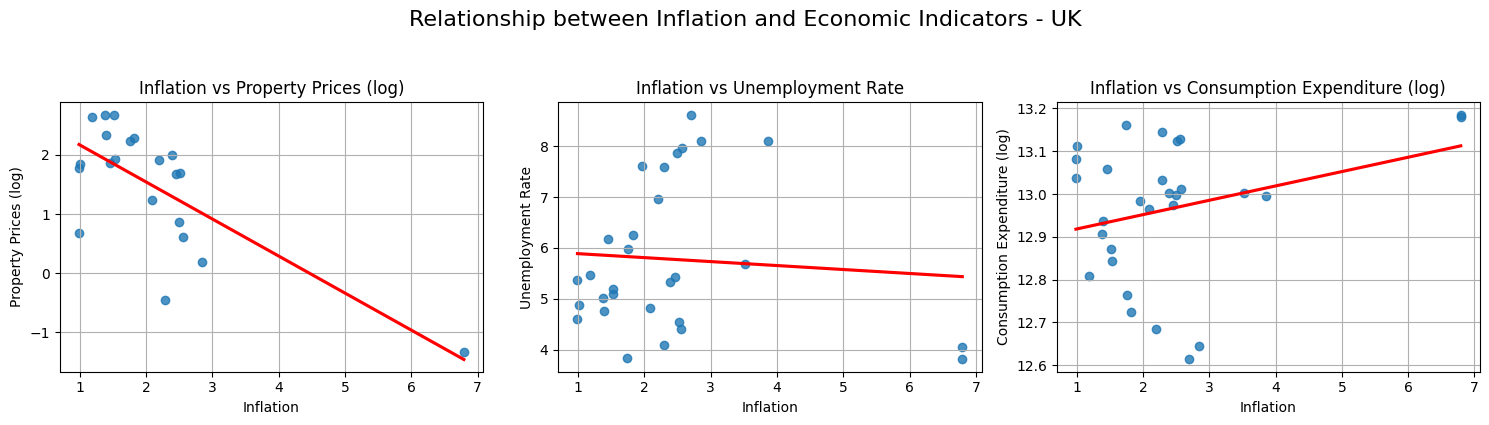

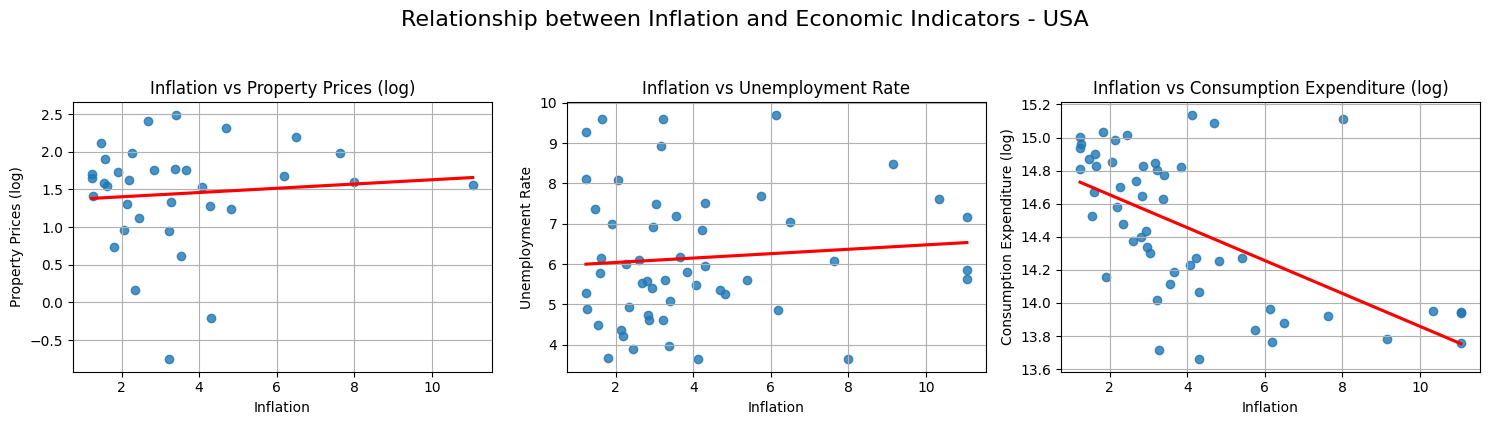

In [110]:
# Function to create scatter plots with regression lines
def regression_plots(df, country_name):
    # Define dependent variables and their labels
    plot_vars = [
        ('Log_Property_Prices', 'Property Prices (log)'),
        ('Unemployment_Rate', 'Unemployment Rate'),
        ('Log_Consumption_Expenditure', 'Consumption Expenditure (log)')
    ]

    # Create subplots
    plt.figure(figsize=(15, 4))

    for i, (var, label) in enumerate(plot_vars):
        plt.subplot(1, 3, i + 1)
        sns.regplot(
            data=df,
            x='Inflation',
            y=var,
            ci=None,
            line_kws={"color": "red"}
        )
        plt.title(f'Inflation vs {label}')
        plt.xlabel('Inflation')
        plt.ylabel(label)
        plt.grid(True)

    plt.suptitle(f'Relationship between Inflation and Economic Indicators - {country_name}', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# Apply the regression plotting function for each country
for country, df in merged_datasets.items():
    regression_plots(df, country)


In [111]:
# Function to run OLS regressions and perform hypothesis testing
def hypothesis_testing(df, country_name):
    # Define independent variable with a constant
    X = df[['Inflation']]
    X = sm.add_constant(X)

    # Define dependent variables
    dependent_vars = {
        'Log_Property_Prices': df['Log_Property_Prices'],
        'Unemployment_Rate': df['Unemployment_Rate'],
        'Log_Consumption_Expenditure': df['Log_Consumption_Expenditure']
    }

    # Store results
    hypothesis_results = []

    for name, Y in dependent_vars.items():
        model = sm.OLS(Y, X, missing='drop').fit()
        coef = model.params['Inflation']
        intercept = model.params['const']
        r_squared = model.rsquared
        p_value = model.pvalues['Inflation']

        decision = 'Reject H₀' if p_value < 0.05 else 'Fail to Reject H₀'

        hypothesis_results.append({
            'Dependent Variable': name,
            'Coefficient (Inflation)': round(coef, 4),
            'Intercept': round(intercept, 4),
            'R-squared': round(r_squared, 4),
            'p-value (Inflation)': round(p_value, 4),
            'Hypothesis Decision': decision
        })

    # Create results table
    summary_df = pd.DataFrame(hypothesis_results)

    print(f"\nHypothesis Testing Results: {country_name}")
    print(summary_df)

# Apply the hypothesis testing for each country
for country, df in merged_datasets.items():
    hypothesis_testing(df, country)



Hypothesis Testing Results: Canada
            Dependent Variable  Coefficient (Inflation)  Intercept  R-squared  \
0          Log_Property_Prices                  -0.0630     4.5315     0.1929   
1            Unemployment_Rate                  -0.0292     7.9709     0.0026   
2  Log_Consumption_Expenditure                  -0.0793    12.7505     0.3720   

   p-value (Inflation) Hypothesis Decision  
0               0.0009           Reject H₀  
1               0.7154   Fail to Reject H₀  
2               0.0000           Reject H₀  

Hypothesis Testing Results: UK
            Dependent Variable  Coefficient (Inflation)  Intercept  R-squared  \
0          Log_Property_Prices                  -0.6261     2.7952     0.5274   
1            Unemployment_Rate                  -0.0779     5.9651     0.0057   
2  Log_Consumption_Expenditure                   0.0335    12.8848     0.0853   

   p-value (Inflation) Hypothesis Decision  
0               0.0002           Reject H₀  
1           